<a href="https://colab.research.google.com/github/dforteza/CIFAR-100/blob/main/cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
import keras
get_ipython().run_line_magic('matplotlib', 'inline')
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize
import seaborn as sns
import cv2

#Introdución al Problema



En el presente trabajo se propone la creación de un modelo de red neuronal convolucional (CNN) para la clasificación de imágenes en 100 categorías. El conjunto de datos utilizado será el CIFAR-100, que consta de 600 imágenes de 32x32 píxeles por categoría, con un total de 60.000 imágenes de entrenamiento y 10.000 imágenes de prueba.
El objetivo del trabajo es diseñar un modelo que sea capaz de alcanzar la mayor precisión posible en los datos de prueba. Para ello, se seguirá un enfoque metodológico basado en la construcción de un modelo base y su posterior mejora mediante la incorporación de nuevos componentes o la modificación de los parámetros existentes.
En la primera parte del trabajo se realizará una descripción del conjunto de datos CIFAR-100, así como una introducción a las CNN. En la segunda parte se presentará la metodología seguida para el diseño y entrenamiento del modelo. En la tercera parte se mostrarán los resultados obtenidos y se realizarán algunas reflexiones sobre las posibles mejoras que podrían aplicarse al modelo.

**DESCRIPCIÓN DEL CONJUNTO DE DATOS**

El conjunto de datos CIFAR-100 (Instituto Canadiense de Investigación Avanzada, 100 clases) es un subconjunto del conjunto de datos Tiny Images y consta de 60000 imágenes en color de 32x32. Las 100 clases del CIFAR-100 se agrupan en 20 superclases. Hay 600 imágenes por clase. Cada imagen viene con una etiqueta "fina" (la clase a la que pertenece) y una etiqueta "gruesa" (la superclase a la que pertenece). Hay 500 imágenes de entrenamiento y 100 imágenes de prueba por clase.


En primer lugar, se carga la base de datos con los datos mencionados.

In [ ]:
# Descargamos la base de datos
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar100.load_data()

# Tamaño de los conuntos
print(f"x_train shape: {train_data.shape}")
print(f"y_train shape: {train_labels.shape}")
print(f"x_test shape: {test_data.shape}")
print(f"y_test shape: {test_labels.shape}")

# Número de muestras
print(f"Train: {train_data.shape[0]}")
print(f"Test: {test_data.shape[0]}")

# Data format
print(type(train_data))
print(type(train_labels))

169001437/169001437 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Train: 50000
Test: 10000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


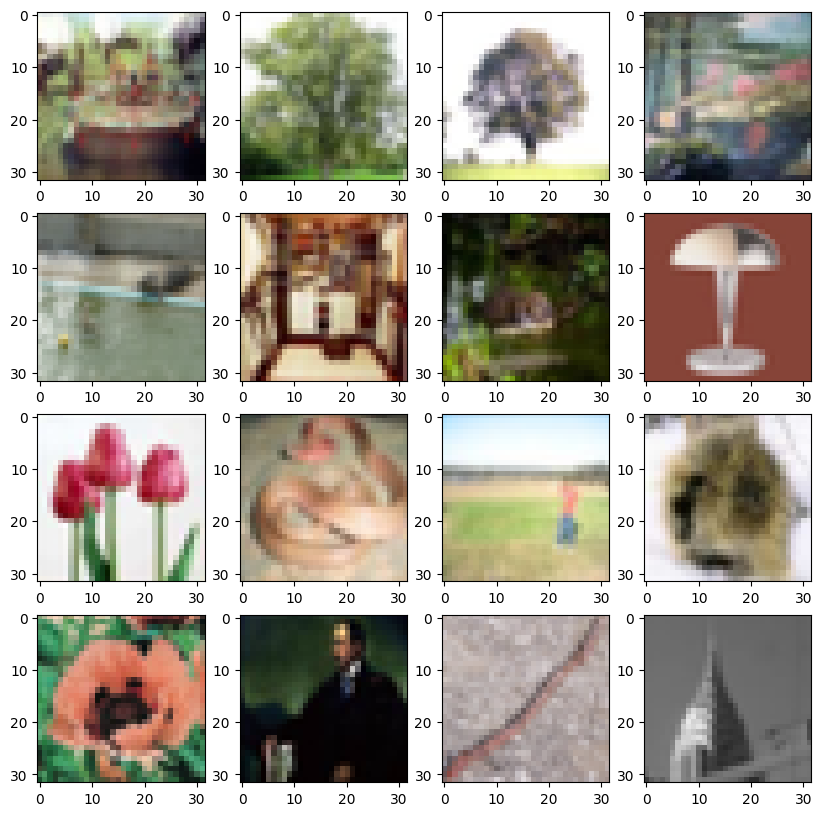

In [ ]:
# Show randomly 16 images in the CIFAR-100
plt.figure(figsize=(10, 10))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(train_data[rand_num])

##Preprocesamiento de los datos

In [ ]:
from keras.utils import to_categorical
# Normalize images
train_data = train_data.astype('float32')/255
test_data = test_data.astype('float32')/255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
from sklearn.model_selection import train_test_split
# Split: Divide los datos de entrenamiento en entrenamiento y validación con razón de 80/20
train_x, val_x, train_y, val_y = train_test_split(train_data, train_labels,
                                                  test_size = 0.2,
                                                  random_state = 123) # para que la partición siempre sea de la misma manera

In [ ]:
# Se definen variables que van a contener los resultados de los entrenamientos
HISTORY = []
TEST_LOSS = []
TEST_ACC = []

In [ ]:
#Se definen las funciones a utilizar durante el desarrollo de la practica
import matplotlib.pyplot as plt

#Gráfica la pérdida y precisión del modelo seleccionado
def training_plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

# Curvas de aprendizaje
"""
Notas: Los elementos de HISTORY son diccionarios que contienen los nombres de las métricas como claves
y sus valores (.values()) son listas con los valores de las métricas durante el entrenamiento model.fit
"""
def curvas_aprendizaje(HISTORY, nfilas, ncol, size = (18,10), title = []):
    # Función para imprimir las curvas de aprendizaje en una rejilla de nfilas x ncol
    # Argumentos: HISTORY = Lista con variables history de keras (obtenidas de model.fit)
    #        nfilas, ncol = Nº de filas y columnas de la rejilla
    #                size = Tamaño total de la rejilla (por defecto es (18,10))
    # !Importante: El nº total de filas x col debe ser superiror al de los elementos pasados como argumento en HISTORY
    if len(HISTORY) > nfilas*ncol:
        print("Error. Dimensiones incompatibles")
        return 0
    else:
        fig = plt.figure(figsize=size) # Especifica tamaño de la figura

        for i, registro in enumerate(HISTORY):

            plt.subplot(nfilas, ncol, i+1) # Añade subplot (gráfica para un modelo)
            if title:
              plt.title(title[i])
            else:
              plt.title("Modelo " + str(i+1)) # Formato de cada gráfica
            plt.xlabel('Épocas')
            plt.ylim((0,2))

            acc = registro.history['accuracy']
            loss = registro.history['loss']

            x = list(range(1, len(acc) + 1))

            plt.plot(x, loss, 'o-') # Imprime
            plt.plot(x, acc, 'o-')

            plt.xticks(x)
            plt.legend(list(registro.history.keys()))
            plt.text(len(x), loss[len(loss)-1], str(round(loss[len(loss)-1],3))) # Valor punto final  loss
            plt.text(len(x), acc[len(acc)-1], str(round(acc[len(acc)-1],3))) # Valor punto final  loss

    fig.tight_layout()
    plt.show()

# Gráfico de barras horizontales
def testerror_testacc(ERROR, ACC, titles, size = (12,12)):
    fig = plt.figure(figsize=size) # Especifica tamaño de la figura

    # Ordena pérdida en orden ascendente y precisión en orden descendente
    sorted_err = dict(zip(titles, ERROR))
    sorted_err = dict(sorted(sorted_err.items(), key = lambda x: x[1], reverse=True))

    sorted_acc = dict(zip(titles, ACC))
    sorted_acc = dict(sorted(sorted_acc.items(), key = lambda x: x[1]))

    # Gráfica
    plt.subplot(1, 2, 1)
    plt.barh(list(sorted_err.keys()), list(sorted_err.values()))
    plt.title('Test error')

    plt.subplot(1,2,2)
    plt.barh(list(sorted_acc.keys()), list(sorted_acc.values()), color='orange')
    plt.title('Test accuracy')

    fig.tight_layout()
    plt.show()

Medida del Éxito

Con la intención de evaluar el resultado de los diferentes modelos se definen los siguientes indicadores de servicio, que se aplicarán a todos los modelos utilizados en igualdad de condiciones. Los indicadores de servicio se denominan también "Key Performance Indicator"(KPI) y su cálculo permite una valoración objetiva de cada modelo utilizado.

El primer indicador de servicio propuesto es la precisión obtenida con los datos de test. Esta medida nos otorgará la eficiencia en la identificación de las subclases con imágenes nunca antes vistas. Su fórmula viene dada por:



```
Accuracy = True Positive / (True Positive + False Positive)
```



El segundo indicador a considerar es el tiempo de ejecución en igualdad de condiciones de uds. de procesamiento (4 GPUs). El tiempo de ejecución sobre las mismas capacidades de procesamiento es proporcional a la complejidad de los modelos.

#Modelos

Para comparar la mejora del rendimiento en función de los cambios aplicados a un modelo que llamaremos modelo base o de referencia se obtendrán los KPIs definidos anteriormente.

La evolución de los modelos pretende ser progresiva desde el modelo base que es el más simple. A continuación se evaluará el modelo base introduciendo la técnica de *"Data Augmentation"*  con el objetivo de incrementar el volumen de datos de aprendizaje con los datos de entrenamiento. Por último, se aplicará un modelo optimizado utilizando de nuevo *"Data Agumentation"*

##Modelo Base

El modelo base consta de 13.870.484 párametros entrenables y está formado por 3 pilas de capas convolucionales con función de activación Relu seguidas cada una de ellas por una capa de pooling, 2 capas densas con función de activación Relu y una última capa densa con función de activación softmax. Esta última se corresponde con la capa de salida.

A continuación se muestra un esquema de la red:

*   Capa de entrada
*   [CONV -> RELU] x 2
*   MAX POOL
*   [CONV -> RELU] x 2
*   MAX POOL
*   [CONV -> RELU] x 2
*   MAX POOL
*   FLATTEN
*   [DENSE -> RELU] x 2
*   [DENSE -> SOFTMAX] -> Capa de salida


Las especificaciones de los parámetros utilizados en la construcción del modelo se muestran a continuación:

1.   En cada capa convolucional se utiliza `padding = "same"`, es decir, se añadan tantas filas y columnas de ceros para que la salida tenga la misma dimensión que la entrada para preservar el tamaño espacial.
2.   Se utiliza ReLU en las capas convolucionales debido a su eficiencia en rendimiento en términos de precisión por encima de otras funciones de activación probadas (sigmoid y tang).
3.   Se ha utilizado un kernel size de 3x3 para todas las capas convolucionales ya que se quería extraer la mayoría de los detalles de las imágenes.
4.   Max pool de tamaño 2x2 ha ofrecido mejores rendimientos que otras opciones como average pool o global pool. Además utilizar un stride de tamaño 2 nos ha permitido obtener un balance entre rendimiento y precisión.
5.   El número de filtros utilizados en la primera pila de
capas convolucionales es 128, 256 y 512 para la tercera. La obtención de estos parámetros empezó desde 32, 64 y 128 y fue incrementandose gradualmente hasta los resultados obtenidos.
6.   Tres capas completamente conectadas con 1000 unidades en las dos primeras capas y 100 unidades (unidades iguales a la número de clases) en la última capa (de salida) han sido utilizadas para hacer que la red sea densa y aprenda las características obtenidas del proceso convolucional. Esta combinación de unidades y capas ayudó a que la red clasificara imágenes con más precisión (5% más) que la red con sólo dos capas completamente conectadas.










In [ ]:
#Modelo base
model_ba= Sequential()

#Capa 1
#convolucion
model_ba.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=(32,32,3)))
model_ba.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
#pooling
model_ba.add(MaxPool2D(pool_size=2, strides=2))

#Capa 2
#convolucion
model_ba.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model_ba.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
#pooling
model_ba.add(MaxPool2D(pool_size=2, strides=2))

#Capa 3
#convolution
model_ba.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model_ba.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model_ba.add(MaxPool2D(pool_size=2, strides=2))

#flattening
model_ba.add(Flatten())

#1º capa densa
model_ba.add(Dense(units=1000, activation="relu"))
#2º capa densa
model_ba.add(Dense(units=1000, activation="relu"))

#capa de salida
model_ba.add(Dense(units=100, activation="softmax"))

In [ ]:
model_ba.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 128)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                   

Debido a la restricción del entorno de ejecución Google Colab en memoria se ha entrenado el modelo durante 100 épocas manteniendo un `batch_size = 64`. Remarcar que un batch_size de 32 ofrecía una pequeña mejora en el rendimiento en cuanto a precisión pero un incremento de tiempo de ejecución más elvado.

Para la elcción del **optimizador** se han comparado los optimizadores RMSProp, Adam y Nadam con distintas tasas de aprendizaje (0.01, 0,001, 0.0001 y 0.00001) y atendiendo a la precisión obtenida por el modelo base con cada uno de los casos se elige la opción Nadam con `learning rate' = 0.0001`.

In [ ]:
epochs = 100
batch_size = 64
optimizer_ba = keras.optimizers.Nadam(learning_rate=0.0001)

#model compiling
model_ba.compile(optimizer=optimizer_ba, loss='categorical_crossentropy', metrics=['accuracy'])

El uso de los callbacks `EarlyStopping()` y `ModelCheckpoint()` permite guardar el modelo óptimo sin desperdiciar recursos de memoria. Para ello se establece como valor de rendimiento la pérdida con los datos de validación con la intención de evitar el sobreentrenamiento y se le da una paciencia de 20.
La paciencia establece los grados de libertad de decidir cuando detener el entrenamiento, en este caso, si la pérdida con los datos de validación empeora durante 20 épocas.



In [ ]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop_ba = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#saving the model checkpoint for the best model
model_checkpoint_ba = ModelCheckpoint('Checkpoint_BaseModel.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
# Entrenamiento del modelo
import time
training_start = time.time()
history_ba = model_ba.fit(train_x, train_y,
                      batch_size= batch_size,
                      epochs=epochs,
                      validation_data = (val_x, val_y),
                      callbacks=[early_stop_ba, model_checkpoint_ba],
                      verbose = 1)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 3.9635 - accuracy: 0.0936
Epoch 1: val_loss improved from inf to 3.41795, saving model to Checkpoint_BaseModel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 41s 40ms/step - loss: 3.9635 - accuracy: 0.0936 - val_loss: 3.4180 - val_accuracy: 0.1805
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 3.1532 - accuracy: 0.2304
Epoch 2: val_loss improved from 3.41795 to 2.97726, saving model to Checkpoint_BaseModel.h5
625/625 [==============================] - 26s 41ms/step - loss: 3.1532 - accuracy: 0.2304 - val_loss: 2.9773 - val_accuracy: 0.2746
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 2.6791 - accuracy: 0.3230
Epoch 3: val_loss improved from 2.97726 to 2.72538, saving model to Checkpoint_BaseModel.h5
625/625 [==============================] - 26s 41ms/step - loss: 2.6791 - accuracy: 0.3230 - val_loss: 2.7254 - val_accuracy: 0.3153
Epoch 4/100
625/625 [==============================] - ETA: 0s - loss: 2.2875 - accuracy: 0.4069
Epoch 4: val_loss improved from 2.72538 to 2.56672, saving model to Checkpoint_BaseModel.h5
625/625 [=========================

In [ ]:
HISTORY.append(history_ba)

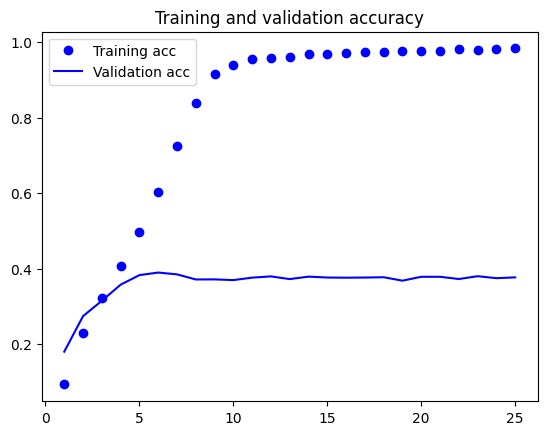

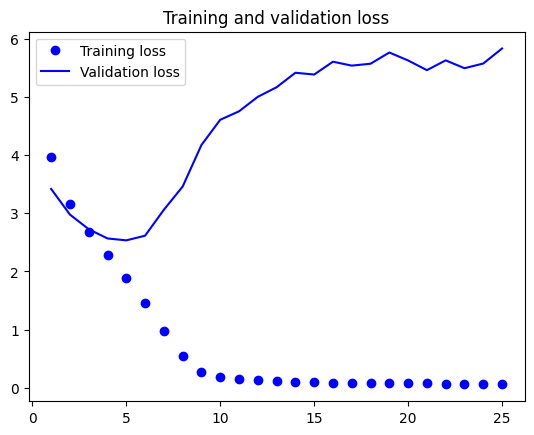

In [ ]:
# Visualize training process
training_plot(history_ba)

Tras entrenar el modelo se observa que antes de la epoch 20 el modelo ha obtenido con los datos de entrenamiento una precisión próxima a la máxima. Además a partir de la gráfica de pérdida se observa que el modelo empieza a sobreentrenar demasiado rápido.

Todo esto significa que el modelo se está acoplando demasiado rápido a los datos de entrenamiento y no esta permitiendo converjer con los datos de validación.

####Rendimiento

In [ ]:
scores_ba = model_ba.evaluate(test_data, test_labels)
TEST_LOSS.append(scores_ba[0])
TEST_ACC.append(scores_ba[1])
print(f'accuracy on test set: {model_ba.metrics_names[1]} of {scores_ba[1]*100}')

313/313 [==============================] - 3s 7ms/step - loss: 5.7407 - accuracy: 0.3784
accuracy on test set: accuracy of 37.83999979496002


Con los datos anteriormente descritos se obtienen los siguientes valores:
*   Tiempo de ejecución: ~644 s en 25 epochs.
*   Precisión con los datos de test: ~37%



##Modelo Base con Data Augmentation

###Data Augmentation

Uno de los principales problemas para la convergencia de cualquier modelo con esta base de datos es la escasez de imágenes por clase en la base de datos (50.000 imágenes repartidas en 100 clases da lugar a 500 imágenes por clase). Para paliar este problema se podría aumentar el número de imágenes or clase añadiendo más pero esto supondría un problema debido a la limitación de memoria establecida por Google Colab. Con estos antecedentes se presenta la técnica DataAugmentation mediante Keras ImageDataGenerator.

 Keras ImageDataGenerator es una técnica que permite aumentar tu número de imágenes en tiempo real mientras tu modelo aún se está entrenando sin suponer un coste de memoria adicional. Consiste en la aplicación de transformaciones sobre las imágenes tales como: rotaciones y traslaciones, aumento y disminución de brillo y zoom entre otras. De esta manera se consiguen datos sintéticos para mejorar el entrenamiento del modelo.

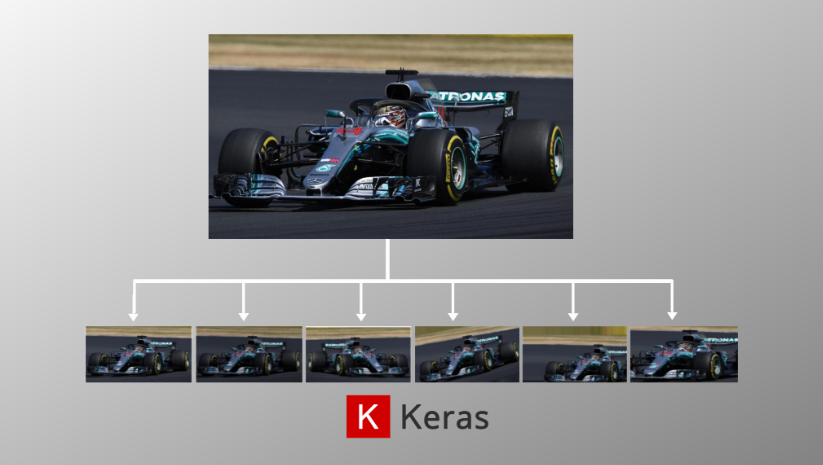

###Modelo

In [ ]:
#Modelo base
model_DA= Sequential()

#Capa 1
#convolucion
model_DA.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=(32,32,3)))
model_DA.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
#pooling
model_DA.add(MaxPool2D(pool_size=2, strides=2))

#Capa 2
#convolucion
model_DA.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model_DA.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
#pooling
model_DA.add(MaxPool2D(pool_size=2, strides=2))

#Capa 3
#convolution
model_DA.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model_DA.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model_DA.add(MaxPool2D(pool_size=2, strides=2))

#flattening
model_DA.add(Flatten())

#1º capa densa
model_DA.add(Dense(units=1000, activation="relu"))
#2º capa densa
model_DA.add(Dense(units=1000, activation="relu"))

#capa de salida
model_DA.add(Dense(units=100, activation="softmax"))

In [ ]:
model_DA.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                 

In [ ]:
optimizer_DA = keras.optimizers.Nadam(learning_rate=0.0001)

#model compiling
model_DA.compile(optimizer=optimizer_DA, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop_DA = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#saving the model checkpoint for the best model
model_checkpoint_DA = ModelCheckpoint('CheckPoint_DataAug.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

Se aplica una el parámetro rotation_range para provocar una rotación de 20º y horizontal flip para voltear la imagen a lo largo del eje horizontal. Estos cambios se aplican a todas las imágenes de entrenamiento.

In [ ]:
data_gen = ImageDataGenerator(
            rotation_range=20,
    horizontal_flip=True)

data_gen.fit(train_x, seed = 123)

In [ ]:
# Entrenamiento del modelo
import time
history_DA = model_DA.fit(data_gen.flow(train_x,train_y,
                    batch_size=batch_size,
                    seed=123),
                    epochs=epochs,
                    steps_per_epoch=train_x.shape[0] // batch_size,
                    validation_data=(val_x, val_y),
                    callbacks=[early_stop_DA, model_checkpoint_DA],
                    verbose=1)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 3.9556 - accuracy: 0.0920
Epoch 1: val_loss improved from inf to 3.43775, saving model to CheckPoint_DataAug.h5
625/625 [==============================] - 41s 58ms/step - loss: 3.9556 - accuracy: 0.0920 - val_loss: 3.4378 - val_accuracy: 0.1790
Epoch 2/100
624/625 [============================>.] - ETA: 0s - loss: 3.2226 - accuracy: 0.2187
Epoch 2: val_loss improved from 3.43775 to 3.02428, saving model to CheckPoint_DataAug.h5
625/625 [==============================] - 32s 51ms/step - loss: 3.2221 - accuracy: 0.2187 - val_loss: 3.0243 - val_accuracy: 0.2584
Epoch 3/100
624/625 [============================>.] - ETA: 0s - loss: 2.8387 - accuracy: 0.2914
Epoch 3: val_loss improved from 3.02428 to 2.79115, saving model to CheckPoint_DataAug.h5
625/625 [==============================] - 32s 51ms/step - loss: 2.8390 - accuracy: 0.2914 - val_loss: 2.7911 - val_accuracy: 0.3009
Epoch 4/100
625/625 [=======================

In [ ]:
HISTORY.append(history_DA)

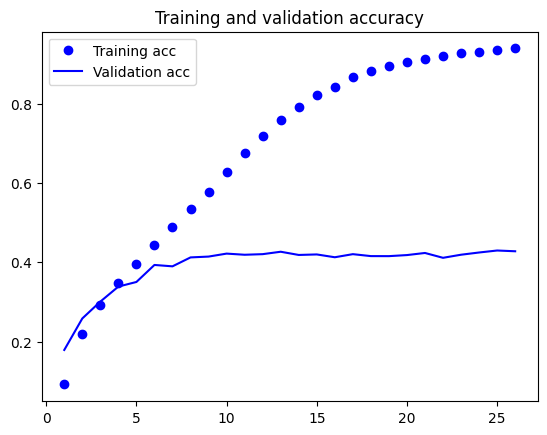

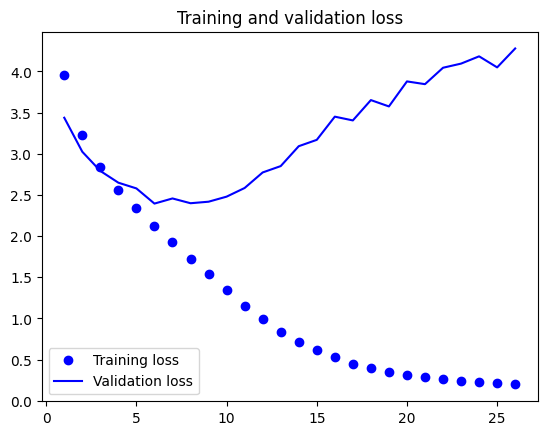

In [ ]:
# Visualize training process
training_plot(history_DA)

De las gráficas se observa que el modelo, a partir de la época 20, obtiene una precisión elevada (o una pérdida muy baja) con los datos de entrenamiento. A parte, de los datos de validación se observa que el modelo converje hacia una precisión del ~40% y que antes de la época 10 el modelo vuelve a sobreentrenar.

Todo esto significa que el modelo se está acoplando demasiado rápido a los datos de entrenamiento y no esta permitiendo converjer adecuadamente con los datos de validación.

####Rendimiento

In [ ]:
scores_DA = model_DA.evaluate(test_data, test_labels)
TEST_LOSS.append(scores_DA[0])
TEST_ACC.append(scores_DA[1])

print(f'accuracy on test set: {model_DA.metrics_names[1]} of {scores_DA[1]*100}')

313/313 [==============================] - 2s 7ms/step - loss: 4.2582 - accuracy: 0.4311
accuracy on test set: accuracy of 43.11000108718872


Con los datos anteriormente descritos se obtienen los siguientes valores:
*   Tiempo de ejecución: ~1627 s en 26 epochs.
*   Precisión con los datos de test: ~44%



##Modelo Optimizado con Data Augmentation

###Optimizadores

**Dropout** se utiliza como una técnica de regularización cuyo objetivo es evitar el sobreajuste al garantizar que ninguna unidad sea codependiente.

Consiste en consiste en retirar (poner a cero) aleatoriamente un número de características de salida de la capa durante el entrenamiento. En cada epoch cada neurona tiene una tasa o probabilidad de estar inactiva. La “tasa de dropout” es la fracción de características que se ponen a 0 (entre 0.2 a 0.5).

**Batch Normalization** es uno de los métodos diseñados para evitar problemas en el descenso estocástico del gradiente a través de la normalización de los inputs de las capas y su posterior transformación. Para ello Batch Normalization actúa como una capa donde realiza 2 acciones:

Normaliza los valores introducidos.

zi=γ⊗x^i+β  donde

γ  es un factor escalar (inicializado como 1).

β  es un factor de compensación (inicializado como 0).

Ventajas:

*   Vuelve la red más rápida y estable
*   Se logra mayor precisión en la red en menos epochs lo que puede desembocar en un mayor rendimiento de este si se mantiene el número inicial de epochs.

El **Dropout** se ha utilizado en todas las capas con valor de 0.2 en la capa de entrada y 0.5 en el resto de capas. La configuración configuración de 0.2 y 0,5 funcionó bien y fue
También es computacionalmente eficiente.

La elección de dropout con valor de 0.2 en la primera capa convolucional es debido a que al usar un valor de 0.5 el modelo obtiene menos precisión. Esto se debe a que al suprimir la mitad de parámetros en la primera capa estamos impidiendo que se traslade toda la información de forma adecuada.

NOTA:


###Modelo

In [ ]:
#initializing CNN model
model_op = Sequential()

#Stack 1
#convolution
model_op.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=(32,32,3)))
model_op.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
#pooling
model_op.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model_op.add(Dropout(0.2))

#Stack 2
#convolution
model_op.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model_op.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
#pooling
model_op.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model_op.add(Dropout(0.5))

#Stack 3
#convolution
model_op.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model_op.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model_op.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model_op.add(Dropout(0.5))

#flattening
model_op.add(Flatten())

#full connection
model_op.add(Dense(units=1000, activation="relu"))
#dropout
model_op.add(Dropout(0.5))

#full connection
model_op.add(Dense(units=1000, activation="relu"))
#dropout
model_op.add(Dropout(0.5))

#output layer
model_op.add(Dense(units=100, activation="softmax"))

**Explicación suma de parámetros**
La capa convolucional va recorriendo la imagen en ventanas de 3x3 creando así una capa oculta de 26x26 (28 píxeles - 3 de las ventanas + 1 de la primera iteración = 26) y un padding de "same" para preservar las dimensiones de la imagen original. El cálculo de parámetros se hará con la siguiente fórmula: parámetros = (tamaño del kernel(largo) x tamaño del kernel(ancho) x número de canales de entrada + 1) x número de filtros. Con esta fórmula nuestra primera capa convolucional tendrá los siguientes parámetros: (3 x 3 x 3 + 1) x 128 = 3584.
Nuestra segunda capa convolucional tendrá la siguiente cantidad de parámetros: (3 x 3 x 128(número de canales de entrada proveniente de la capa anterior) + 1) x 128 = 147584.
La tercera tendrá: (3 x 3 x 128 + 1) x 256 = 295168.
La cuarta tendrá: (3 x 3 x 256 + 1) x 256 = 590080.
La quinta tendrá: (3 x 3 x 256 + 1) x 512 = 1180160.
La sexta tendrá: (3 x 3 x 512 + 1) x 512 = 2359808.
Para el calculo de parámetros de la capa densa seguiremos la siguiente fórmula: Parámetros=(Entradas + 1) × neuronas. En nuestro caso será: (8192 + 1) x 1000 = 8193000. Para nuestra segunda capa densa el cálculo será:  (1000 + 1) x 1000 = 1001000. Para nuestra tercera capa densa el cálculo será: (1001 + 1) x 100 = 100100. El resultado total de los parámetros será la suma de lo calculado anteriormente.

In [ ]:
model_op.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 256)       590080    
                                                      

In [ ]:
epochs_op = 100
batch_size_op = 64
optimizer_op = keras.optimizers.Adam(learning_rate=0.0001)

#model compiling
model_op.compile(optimizer=optimizer_op, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop_op = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#saving the model checkpoint for the best model
model_checkpoint_op = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
#Aumento de las imagenes de entrenamiento
data_gen = ImageDataGenerator(
            rotation_range=20,
    horizontal_flip=True)

In [ ]:
data_gen.fit(train_x, seed = 123)

In [ ]:
import time
history_op = model_op.fit(data_gen.flow(train_x,train_y,
                    batch_size=batch_size_op,
                    seed=123),
                    epochs=epochs_op,
                    steps_per_epoch=train_x.shape[0] // batch_size,
                    validation_data=(val_x, val_y),
                    callbacks=[early_stop_op, model_checkpoint_op],
                    verbose=1)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 4.5510 - accuracy: 0.0152
Epoch 1: val_loss improved from inf to 4.45239, saving model to best_model.h5
625/625 [==============================] - 39s 54ms/step - loss: 4.5510 - accuracy: 0.0152 - val_loss: 4.4524 - val_accuracy: 0.0292
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 4.1857 - accuracy: 0.0548
Epoch 2: val_loss improved from 4.45239 to 3.88548, saving model to best_model.h5
625/625 [==============================] - 33s 53ms/step - loss: 4.1857 - accuracy: 0.0548 - val_loss: 3.8855 - val_accuracy: 0.0999
Epoch 3/100
624/625 [============================>.] - ETA: 0s - loss: 3.8676 - accuracy: 0.0951
Epoch 3: val_loss improved from 3.88548 to 3.60492, saving model to best_model.h5
625/625 [==============================] - 39s 62ms/step - loss: 3.8673 - accuracy: 0.0953 - val_loss: 3.6049 - val_accuracy: 0.1503
Epoch 4/100
624/625 [============================>.] - ETA: 0s - los

In [ ]:
HISTORY.append(history_op)

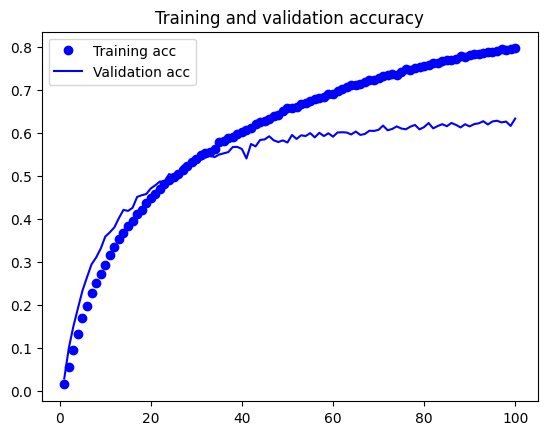

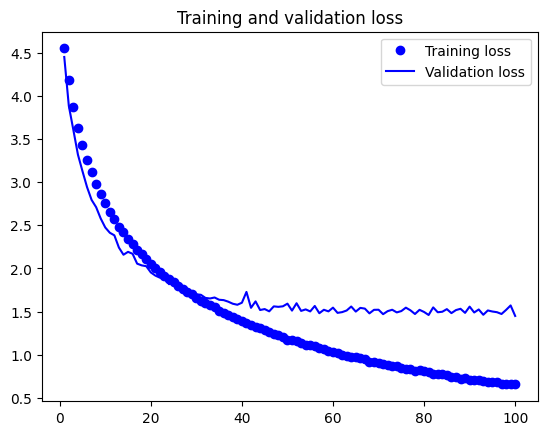

In [ ]:
# Visualize training process
training_plot(history_op)

####Rendimiento

In [ ]:
scores_op = model_op.evaluate(test_data, test_labels)
TEST_LOSS.append(scores_op[0])
TEST_ACC.append(scores_op[1])
print(f'accuracy on test set: {model_op.metrics_names[1]} of {scores_op[1]*100}')

313/313 [==============================] - 2s 7ms/step - loss: 1.4089 - accuracy: 0.6413
accuracy on test set: accuracy of 64.13000226020813


Con los datos anteriormente descritos se obtienen los siguientes valores:
*   Tiempo de ejecución: ~5317 s.
*   Precisión con los datos de test: ~65%



In [ ]:
# Name of all classes in CIFAR-100
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale',
'aquarium' ,'fish', 'ray', 'shark', 'trout',
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
'bottles', 'bowls', 'cans', 'cups', 'plates',
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe',
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
'bear', 'leopard', 'lion', 'tiger', 'wolf',
'bridge', 'castle', 'house', 'road', 'skyscraper',
'cloud', 'forest', 'mountain', 'plain', 'sea',
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
'crab', 'lobster', 'snail', 'spider', 'worm',
'baby', 'boy', 'girl', 'man', 'woman',
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
'maple', 'oak', 'palm', 'pine', 'willow',
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

In [ ]:
# Translate categorial to array for drawing confusion matrix
from sklearn.metrics import confusion_matrix
from numpy import argmax
prediction = []
true_labels = []

pred = model_op.predict(test_data)
print(test_labels.shape[0])
for i in range(test_labels.shape[0]):
  prediction.append(argmax(pred[i]))
  true_labels.append(argmax(test_labels[i]))

cm = confusion_matrix(prediction, true_labels)

313/313 [==============================] - 2s 6ms/step
10000


In [ ]:
# Calculating f1 score
from sklearn.metrics import f1_score
print(f"f1 score: {f1_score(true_labels, prediction, average='weighted')*100}")

f1 score: 63.92007592259687


#Evolución

A continuación las gráficas correspondientes a la pérdida y precisión con los datos de entrenamiento de los 3 modelos.

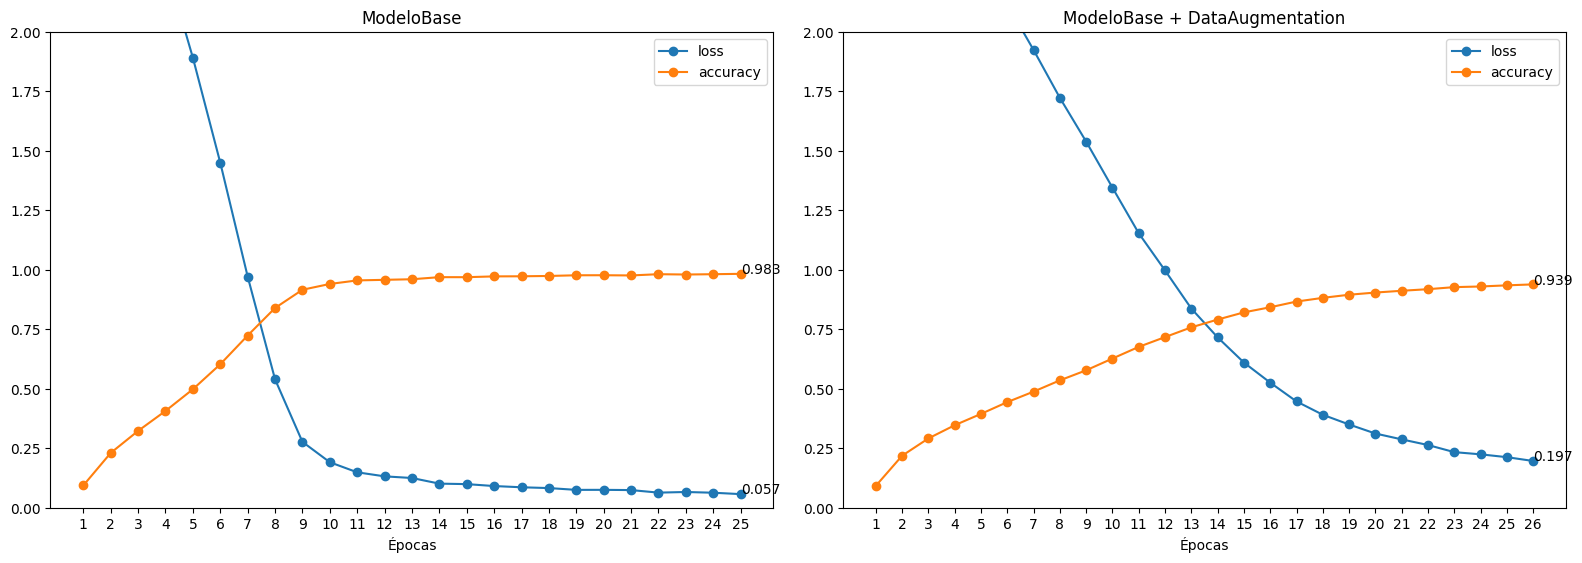

In [ ]:
title = ['ModeloBase', 'ModeloBase + DataAugmentation', 'ModeloOptimizado + DataAugmentation']
curvas_aprendizaje(HISTORY[:2], 3, 2, (16,16), title)

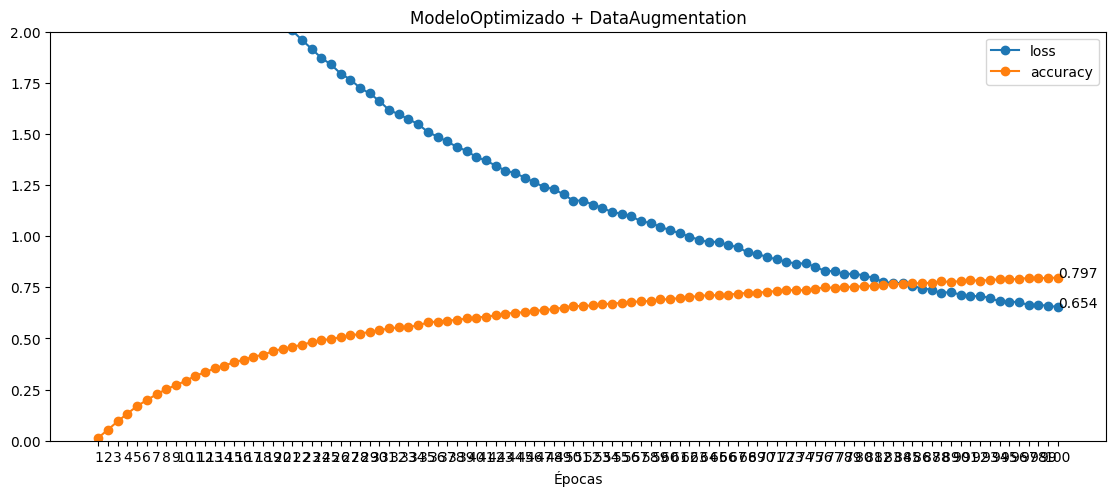

In [ ]:
curvas_aprendizaje(HISTORY[2:], 3, 2, (22,14),
                   title[2:])

Se observa como para el modelo base la pérdida y precisión convergen muy rápidamente alcanzando una cota alta con muy pocas épocas. Para el modelo base con data augmentation ambas medidas convergen más lentamente con un número similar de épocas y para el modelo optimizado con data augmentation la convergencia es mucho más suave en un número de épocas mucho mayor. Suavizar la convergencia del modelo se consigue mediante el uso de optimizadores y data augmentation y consigue que el modelo sea capaz de reconocer de manera más óptima las imágenes de validación.

A continuación se añade una gráfica con los tiempos de ejecución de cada modelo.

El indicador de tiempo nos pueda dar una medida de la complejidad de los distintos modelos ya que los 3 han sido ejecutados en las mismas condiciones de capacidad de proceso y recursos. En la tabla anterior se observa que el algoritmo base es el que se ejecuta más rápidamente. El resultado es lógico ya que es el algoritmo más sencillo aunque la salida del mismo es la menos precisa. En el caso 2 el tiempo se incrementa al igual que la precisión. En el caso 3 el tiempo se incrementa de una manera significativa debido a la mayor complejidad del modelo y al aumento de epochs para alcanzar un incremento significativo de la precisión.

Por último se gráfica por medio de un grafico de barras los datos de pérdida y precisión obtenidos sobre los datos de test.

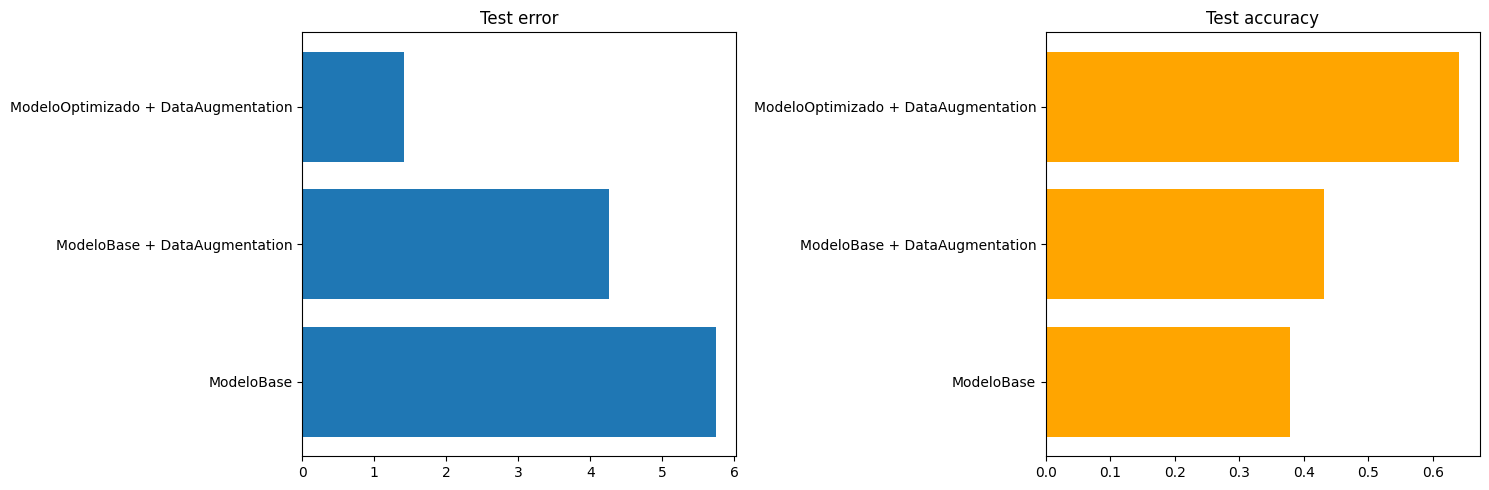

In [ ]:
testerror_testacc(TEST_LOSS, TEST_ACC, title, (15, 5))

Si se comparan el modelo base con el modelo base con data agumentation se aprecia como el uso de la técnica de data augmentaton sobre el modelo base produce en la pérdida una mejoría del 27% aprox. y del 7% aprox. en la precisión.
Al comparar el modelo base con data augmentation con el modelo optimizado con data agumentation se observa que el uso de los optimizadores mejoran significativamente el rendimiento del modelo produciendo una mejoría del 66% respecto a la pérdida y del 20% respecto a la precisión.

Remarcar que la mejoría en los datos de test entre el modelo base con data augmentation y el optimizado es posible debido a la eliminación del sobreentrenamiento el cual impedía que el modelo base con data augmentation se entrenara adecuadamante afectando en su rendimiento.